# Import modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision.transforms.v2 as transforms_v2
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader, Subset
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import KFold

# Set device

In [2]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.xpu.is_available():
    device = torch.device('xpu')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Prepare datasets

In [3]:
# Define training and validation transforms
training_transform_v2 = transforms_v2.Compose([
    transforms_v2.RandomHorizontalFlip(),
    transforms_v2.RandomResizedCrop(size=256),
    transforms_v2.ToImage(),
    transforms_v2.ToDtype(torch.float32, scale=True),
    transforms_v2.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

validation_transform_v2 = transforms_v2.Compose([
    transforms_v2.ToImage(),
    transforms_v2.ToDtype(torch.float32, scale=True),
    transforms_v2.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
# Load data and split to training, validation and test data
# K-Fold cross validation is implemented for spliting training and validation data

image_data = ImageFolder('ball-images', transform=[transforms_v2.ToImage(), transforms_v2.ToDtype(torch.float32, scale=True)])
training_validation_data, test_data = random_split(image_data, [0.8, 0.2], generator=torch.Generator().manual_seed(42))
k_fold_model = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (training_idx, validation_index) in enumerate(k_fold_model.split(training_validation_data)):
    training_data = Subset(training_validation_data, training_idx)
    validation_data = Subset(training_validation_data, validation_index)

    training_data.dataset.transform = training_transform_v2
    validation_data.dataset.transform = validation_transform_v2

    training_loader = DataLoader(training_data, batch_size=32, shuffle=True)
    validation_loader = DataLoader(validation_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

c:\Users\minhn\anaconda3\envs\dl\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [5]:
label_indices = image_data.class_to_idx
index_labels = {val: key for key, val in label_indices.items()}
index_labels

{0: 'baseball',
 1: 'basketball',
 2: 'croquet_ball',
 3: 'golf_ball',
 4: 'ping_pong_ball',
 5: 'rugby_ball',
 6: 'soccer_ball',
 7: 'tennis_ball',
 8: 'volleyball'}

# Define CNN model class

In [20]:
class BallClassifier(nn.Module):
    def __init__(self, dropout_prop=0.5):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout_prop)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout_prop),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout_prop)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout_prop),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout_prop)
        )
        self.gap_block = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(in_features=256, out_features=len(index_labels))
        )
    
    def forward(self, input):
        conv_1 = self.conv_block_1(input)
        conv_2 = self.conv_block_2(conv_1)
        conv_3 = self.conv_block_3(conv_2)
        # print(conv_3.shape)
        output = self.gap_block(conv_3)
        return output

# Define loss criterion and optimizer

In [ ]:
model = BallClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

model = model.to(device)
criterion = criterion.to(device)

# Train & test the model

In [8]:
model_filename = 'ball_classifier_model.pth'

In [9]:
def test_model(model, criterion, test_dataloader):
    model.eval()
    with torch.no_grad():
        total_loss, correct_predictions = 0., 0.
        for i, (input_batch, target_batch) in enumerate(test_dataloader):

            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)
            output = model(input_batch)
            total_loss += criterion(output.squeeze(-1), target_batch).item()
            predictions = torch.argmax(output, dim=1) # Get index label with highest value after softmax calculation in CE loss function

            correct_predictions += (predictions == target_batch).sum().item()

    # Average for all batches
    average_loss = total_loss / (i + 1)  # Use i + 1 for the total number of batches
    average_accuracy = correct_predictions / len(test_dataloader.dataset)

    return average_loss, average_accuracy

In [10]:
def train_model(n_epochs, model, criterion, optimizer, train_dataloader, val_dataloader, verbose=True, verbose_interval=1):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    model.train()
    for epoch in range(1, n_epochs + 1):
        start = time.time()
        train_loss, correct_predictions = 0., 0.

        for i, (input_batch, target_batch) in enumerate(train_dataloader):
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)
            output = model(input_batch)
            loss_train = criterion(output.squeeze(-1), target_batch)
            predictions = torch.argmax(output, dim=1) # Get index label with highest value after softmax calculation in CE loss function
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

            # accumulate correct prediction
            correct_predictions += (predictions == target_batch).sum().item() # number of correct predictions
            train_loss += loss_train.item()

        average_train_loss = train_loss / (i+1)
        average_train_accuracy = correct_predictions / len(train_dataloader.dataset)

        val_loss, val_accuracy = test_model(model, criterion, val_dataloader)

        train_losses.append(average_train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(average_train_accuracy)
        val_accuracies.append(val_accuracy)

        end = time.time()
        epoch_time = round(end - start, 2)
        if verbose and epoch % verbose_interval == 0:
            print(f'Epoch {epoch}: train_loss {average_train_loss:.3f}, train_accuracy: {average_train_accuracy:.4f},',
                  f'validation_loss {val_loss:.3f}, validation_accuracy: {val_accuracy:.4f}, time = {epoch_time}s')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [32]:
n_epochs = 25
train_losses, val_losses, train_accuracy, val_accuracy = train_model(n_epochs, model, criterion, optimizer, training_loader, validation_loader)
torch.save(model.state_dict(), model_filename)
print(f'Your trained model is saved to {model_filename} successfully!')

Epoch 1: train_loss 2.047, train_accuracy: 0.2705, validation_loss 2.273, validation_accuracy: 0.1718, time = 9.87s
Epoch 2: train_loss 1.928, train_accuracy: 0.3134, validation_loss 1.736, validation_accuracy: 0.3977, time = 8.86s
Epoch 3: train_loss 1.737, train_accuracy: 0.3949, validation_loss 1.693, validation_accuracy: 0.4344, time = 8.84s
Epoch 4: train_loss 1.694, train_accuracy: 0.4204, validation_loss 1.596, validation_accuracy: 0.4498, time = 8.8s
Epoch 5: train_loss 1.651, train_accuracy: 0.4267, validation_loss 1.581, validation_accuracy: 0.4344, time = 9.18s
Epoch 6: train_loss 1.599, train_accuracy: 0.4581, validation_loss 1.575, validation_accuracy: 0.5000, time = 10.19s
Epoch 7: train_loss 1.548, train_accuracy: 0.4904, validation_loss 1.458, validation_accuracy: 0.5097, time = 9.86s
Epoch 8: train_loss 1.498, train_accuracy: 0.5019, validation_loss 1.503, validation_accuracy: 0.5019, time = 9.49s
Epoch 9: train_loss 1.456, train_accuracy: 0.5203, validation_loss 1.437

# Test & inference phase

In [29]:
# Load trained model file
model = BallClassifier()
model = model.to(device)
model.load_state_dict(torch.load(model_filename, map_location=device))
print(f'Your trained model weights are loaded from {model_filename} successfully!')

Your trained model weights are loaded from ball_classifier_model.pth successfully!


In [33]:
test_loss, test_accuracy = test_model(model, criterion, test_loader)
print(f'Test loss: {test_loss:.3f}; Test accuracy: {test_accuracy:.4f}')

Test loss: 1.196; Test accuracy: 0.5972


In [45]:
example_images, example_labels = next(iter(test_loader))

Text(0.5, 1.0, 'Image class to test: basketball')

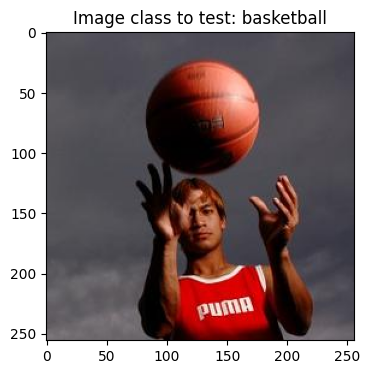

In [46]:
# Show a random example image from test dataset with textual label
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plt.imshow(np.transpose(example_images[2], (1, 2, 0)))
text_label = index_labels[example_labels[2].item()]
ax.set_title(f'Image class to test: {text_label}')

In [47]:
test_image = example_images[2]
test_image = torch.unsqueeze(test_image.to(device), 0)
test_image_output = model(test_image)
#print(test_image_output)
class_index = torch.argmax(test_image_output, dim=1).item()
print(f'Test prediction: {index_labels[class_index]}')

Test prediction: basketball
